In [19]:
import pandas as pd
import numpy as np  
import aqi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime
import itertools
from typing import Tuple, Any, Optional
import json
import pickle
import warnings

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, seasonal_mean

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.saving import register_keras_serializable

# Ignore all warnings
warnings.filterwarnings('ignore')  
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [20]:
df = pd.read_csv(r'D:\aqi_forecast_arima\AQI_forecast_arima\data\historical_pm25_weather.csv')

In [21]:
df

,date,hour,pm25,hour.1,temp,hour.2,humidity
0,1/2/2025,1:00,69.2,1:00,25,1:00,69
1,1/2/2025,2:00,69.3,2:00,25,2:00,74
2,1/2/2025,3:00,66.1,3:00,25,3:00,76
3,1/2/2025,4:00,66.3,4:00,24,4:00,78
4,1/2/2025,5:00,65.9,5:00,24,5:00,80
...,...,...,...,...,...,...,...
355,15/2/2025,20:00,66.8,20:00,31,20:00,53
356,15/2/2025,21:00,69.0,21:00,30,21:00,63
357,15/2/2025,22:00,59.1,22:00,29,22:00,67
358,15/2/2025,23:00,59.0,23:00,29,23:00,68


In [22]:
# Combine 'date' and 'hour' into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['hour'], dayfirst=True)

# Drop unnecessary columns (if they exist)
df = df.drop(columns=['hour'])

# Select the required columns
data = df[['datetime', 'pm25', 'temp', 'humidity']]
data = data.rename(columns={'temp':'temperature'})
#split data
pollutants = data[['datetime','pm25']]
weather = data[['datetime','temperature','humidity']]

In [23]:
data

,datetime,pm25,temperature,humidity
0,2025-02-01 01:00:00,69.2,25,69
1,2025-02-01 02:00:00,69.3,25,74
2,2025-02-01 03:00:00,66.1,25,76
3,2025-02-01 04:00:00,66.3,24,78
4,2025-02-01 05:00:00,65.9,24,80
...,...,...,...,...
355,2025-02-15 20:00:00,66.8,31,53
356,2025-02-15 21:00:00,69.0,30,63
357,2025-02-15 22:00:00,59.1,29,67
358,2025-02-15 23:00:00,59.0,29,68


In [24]:
pollutants

,datetime,pm25
0,2025-02-01 01:00:00,69.2
1,2025-02-01 02:00:00,69.3
2,2025-02-01 03:00:00,66.1
3,2025-02-01 04:00:00,66.3
4,2025-02-01 05:00:00,65.9
...,...,...
355,2025-02-15 20:00:00,66.8
356,2025-02-15 21:00:00,69.0
357,2025-02-15 22:00:00,59.1
358,2025-02-15 23:00:00,59.0


In [25]:
weather

,datetime,temperature,humidity
0,2025-02-01 01:00:00,25,69
1,2025-02-01 02:00:00,25,74
2,2025-02-01 03:00:00,25,76
3,2025-02-01 04:00:00,24,78
4,2025-02-01 05:00:00,24,80
...,...,...,...
355,2025-02-15 20:00:00,31,53
356,2025-02-15 21:00:00,30,63
357,2025-02-15 22:00:00,29,67
358,2025-02-15 23:00:00,29,68


In [28]:
def remove_whitespace_cols(df):
    df.columns = df.columns.str.strip()
    
    return df

def cleaning_data(df):
    df = remove_whitespace_cols(df)
    df['datetime'] = pd.to_datetime(df['datetime'],errors = 'coerce') if 'datetime' in df.columns else ValueError('date column not found!')
    
    for col in df.columns:
        if col != 'datetime':
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
    df = df.sort_values('datetime').reset_index(drop=True)
    
    return df

def calc_aqi(row: pd.Series):
    pollutants = {
        'pm25': aqi.POLLUTANT_PM25,
        'pm10': aqi.POLLUTANT_PM10,
        'o3': aqi.POLLUTANT_O3_8H,
        'no2': aqi.POLLUTANT_NO2_1H,
        'so2': aqi.POLLUTANT_SO2_1H,
        'co': aqi.POLLUTANT_CO_8H
    }
    aqi_values = []
    for pollutant, aqi_pollutant in pollutants.items():
        if pollutant in row and pd.notna(row[pollutant]):
            try:
                aqi_values.append(aqi.to_aqi([(aqi_pollutant, row[pollutant])]))
            except TypeError:
                continue
    
    if len(aqi_values) == 0:
        return np.nan
    
    return np.max(aqi_values)

def preprocess_data(df):
    aqi_df = df[['datetime', 'aqi']].copy()
    aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
    aqi_df.set_index('datetime', inplace=True)
    
    aqi_df['aqi'] = aqi_df['aqi'].interpolate(method='time')
    
    return aqi_df

def load_and_clean_data(df):
    
    df_clean = cleaning_data(df)
    df_clean['aqi'] = df_clean.apply(calc_aqi, axis=1)
    aqi_df = preprocess_data(df_clean)
    logger.info("done cleaning data!")
    return aqi_df


In [29]:
aqi_data = load_and_clean_data(pollutants)
aqi_data.head()

INFO:__main__:done cleaning data!


,aqi
datetime,
2025-02-01 00:00:00,155.0
2025-02-01 01:00:00,158.0
2025-02-01 02:00:00,158.0
2025-02-01 03:00:00,156.0
2025-02-01 04:00:00,157.0


In [64]:
folder_path = r'D:\aqi_forecast_arima\AQI_forecast_arima\results'
aqi_data.to_csv(f"{folder_path}/aqi_data.csv", index=True)

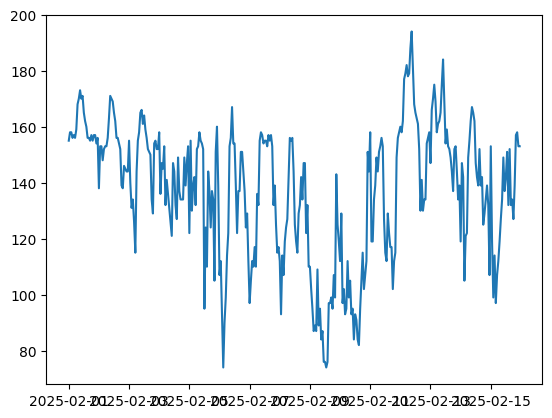

In [30]:
plt.plot(aqi_data['aqi'])
plt.show()

In [39]:
MODEL_DIR = 'models'
ARIMA_MODEL_PATH = os.path.join(MODEL_DIR, "arima_model.pkl")
SARIMA_MODEL_PATH = os.path.join(MODEL_DIR, "sarima_model.pkl")
SARIMAX_MODEL_PATH = os.path.join(MODEL_DIR, "sarimax_model.pkl")
LSTM_MODEL_PATH = os.path.join(MODEL_DIR, "lstm_model.h5")
BEST_ORDER_PATH = os.path.join(MODEL_DIR, "best_sarima_order.json")
os.makedirs(MODEL_DIR, exist_ok=True)

@register_keras_serializable()

def save_sarimax_model(model: Any, model_type: str, model_dir: str = MODEL_DIR) -> None:
    # Ensure that model_type is the correct string (not the full path)
    model_type = model_type.lower()  # Ensures that the type is always lowercase
    model_path = {
        'arima': ARIMA_MODEL_PATH,
        'sarima': SARIMA_MODEL_PATH,
        'sarimax': SARIMAX_MODEL_PATH
    }.get(model_type)

    if model_path is None:
        logger.error(f"Invalid model type: {model_type}. Model was not saved.")
        return

    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    logger.info(f"{model_type} model saved as {model_path}.")

def load_sarimax_model(model_type: str, model_dir: str = MODEL_DIR) -> Optional[Any]:
    model_type = model_type.lower()  # Ensure model_type is always lowercase
    model_path = {
        'arima': ARIMA_MODEL_PATH,
        'sarima': SARIMA_MODEL_PATH,
        'sarimax': SARIMAX_MODEL_PATH
    }.get(model_type)

    if model_path is None:
        logger.error(f"Invalid model type: {model_type}. Cannot load model.")
        return None

    if os.path.exists(model_path):
        with open(model_path, "rb") as f:
            logger.info(f"Loaded {model_type} model from disk.")
            return pickle.load(f)
    else:
        logger.warning(f"{model_type} model file not found at {model_path}.")
        return None

def error_cal(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [40]:
from itertools import product
def save_best_order(order: Tuple[int, int, int],
                    seasonal_order: Tuple[int, int, int, int],
                    filename: str = BEST_ORDER_PATH) -> None:
    if len(seasonal_order) != 4:
        logger.error(f"Invalid seasonal_order format: {seasonal_order}. Must have 4 elements.")
        raise ValueError("`seasonal_order` must be a tuple with four elements.")
    best_order_dict = {"order": order, "seasonal_order": seasonal_order}
    with open(filename, "w") as f:
        json.dump(best_order_dict, f)
    logger.info(f"Best SARIMA order and seasonal_order saved to {filename}")

def load_best_order(filename: str = BEST_ORDER_PATH) -> Optional[dict]:
    if os.path.exists(filename):
        with open(filename, "r") as f:
            return json.load(f)
    logger.warning(f"File not found: {filename}. Returning None.")
    return None

def find_sarima_order(data: pd.Series, seasonal_period=24, max_p=3, max_q=3, max_P=3, max_Q=3) -> None:
    # Check if best order is already saved
    best_order_data = load_best_order()
    if best_order_data:
        best_order = best_order_data["order"]
        best_seasonal_order = best_order_data["seasonal_order"]
        logger.info(f"Loaded best SARIMA order and seasonal order from {BEST_ORDER_PATH}")
    else:
        # Generate all combinations of p, d, q, P, D, Q
        p = q = range(0, max_p + 1)
        P = Q = range(0, max_P + 1)
        d = range(0, 2)  # usually d is either 0 or 1
        D = range(0, 2)  # usually D is either 0 or 1
        seasonal_orders = list(product(P, D, Q))
        non_seasonal_orders = list(product(p, d, q))

        best_aic = np.inf
        best_order = None
        best_seasonal_order = None

        # Grid search for the best SARIMA model based on AIC
        for (p, d, q) in non_seasonal_orders:
            for (P, D, Q) in seasonal_orders:
                try:
                    # Fit SARIMA model
                    model = SARIMAX(data,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, seasonal_period),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit(disp=False)

                    # Compare AIC
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_seasonal_order = (P, D, Q, seasonal_period)
                except Exception as e:
                    # Skip if there is an error in model fitting
                    logger.error(f"Error fitting model with order {(p, d, q)} and seasonal order {(P, D, Q)}: {e}")
                    continue

        if best_order and best_seasonal_order:
            logger.info(f"Best SARIMA Order: {best_order}")
            logger.info(f"Best Seasonal Order: {best_seasonal_order}")
            save_best_order(best_order, best_seasonal_order)
        else:
            logger.warning("No valid SARIMA model found.")
    return best_order,best_seasonal_order

In [42]:
order, s_order = find_sarima_order(aqi_data)

INFO:__main__:Loaded best SARIMA order and seasonal order from models\best_sarima_order.json


In [43]:
print("AQI Min:", aqi_data.min(), "AQI Max:", aqi_data.max())
print("Unique AQI Values:", aqi_data.nunique())


AQI Min: aqi    74.0
dtype: float64 AQI Max: aqi    194.0
dtype: float64
Unique AQI Values: aqi    79
dtype: int64


In [45]:
MODEL_DIR = 'models'
ARIMA_MODEL_PATH = os.path.join(MODEL_DIR, "arima_model.pkl")
SARIMA_MODEL_PATH = os.path.join(MODEL_DIR, "sarima_model.pkl")
SARIMAX_MODEL_PATH = os.path.join(MODEL_DIR, "sarimax_model.pkl")
LSTM_MODEL_PATH = os.path.join(MODEL_DIR, "lstm_model.h5")
BEST_ORDER_PATH = os.path.join(MODEL_DIR, "best_sarima_order.json")
os.makedirs(MODEL_DIR, exist_ok=True)

def fit_arima_sarima_sarimax_model(aqi_df: pd.DataFrame, 
                                   order: Tuple[int, int, int], 
                                   seasonal_order: Optional[Tuple[int, int, int, int]] = None, 
                                   exog_var: Optional[pd.DataFrame] = None,
                                   save_model: bool = True) -> Tuple[Any, pd.Series]:

    
    if seasonal_order is not None and exog_var is None:
        model_path = SARIMA_MODEL_PATH
        model_type = "SARIMA"
    elif seasonal_order is not None or exog_var is not None:
        model_path = SARIMAX_MODEL_PATH
        model_type = "SARIMAX"
    else:
        model_path = ARIMA_MODEL_PATH
        model_type = "ARIMA"


    # Load existing model if it exists
    if os.path.exists(model_path):
        logger.info(f"Loading existing model from {model_path}...")
        model_fit = load_sarimax_model(model_type)
        
        if model_fit is None:
            logger.error(f"Failed to load model from {model_path}. Re-training required.")
        else:
            return model_fit, model_fit.fittedvalues

    # If model does not exist, fit a new model
    logger.info("Fitting ARIMA/SARIMA/SARIMAX model...")

    # Prepare external variables (exog)
    if exog_var is not None:
        exog_var = exog_var.drop(columns=['date'])
        exog_var = exog_var.sort_index()
        exog_var = exog_var.reindex(aqi_df.index).fillna(exog_var.mean())
        aqi_df = aqi_df.loc[exog_var.index]
    
    exog = exog_var.reindex(aqi_df.index) if exog_var is not None else None

    # Fit the model based on the provided orders
    if seasonal_order is None and exog is None:
        model = sm.tsa.ARIMA(aqi_df['aqi'], order=order)
    elif seasonal_order is not None and exog is None:
        model = sm.tsa.SARIMAX(aqi_df['aqi'], order=order, seasonal_order=seasonal_order)
    else:
        model = sm.tsa.SARIMAX(aqi_df['aqi'], order=order, seasonal_order=seasonal_order, exog=exog)

    # Fit the model and get the fitted values
    model_fit = model.fit()
    fitted_values = model_fit.fittedvalues

    # Save the model if required
    if save_model:
        save_sarimax_model(model_fit, model_type)  # Save using the appropriate model type
        summary_path = os.path.join(MODEL_DIR, f"{model_type.lower()}_summary.txt")
        with open(summary_path, "w") as f:
            f.write(model_fit.summary().as_text())
        logger.info(f"{model_type} model fit complete and saved.")
    else:
        logger.info(f"{model_type} model fit complete but not saved.")
    
    return model_fit, fitted_values

In [46]:
arima_model_result = fit_arima_sarima_sarimax_model(aqi_data, order=order)


INFO:__main__:Loading existing model from models\arima_model.pkl...
INFO:__main__:Loaded arima model from disk.


In [47]:
sarima_model_result = fit_arima_sarima_sarimax_model(aqi_data, order=order, seasonal_order=s_order)


INFO:__main__:Loading existing model from models\sarima_model.pkl...
INFO:__main__:Loaded sarima model from disk.


In [48]:
sarimax_model_result = fit_arima_sarima_sarimax_model(aqi_data, order=order, seasonal_order=s_order, exog_var=weather)


INFO:__main__:Loading existing model from models\sarimax_model.pkl...
INFO:__main__:Loaded sarimax model from disk.


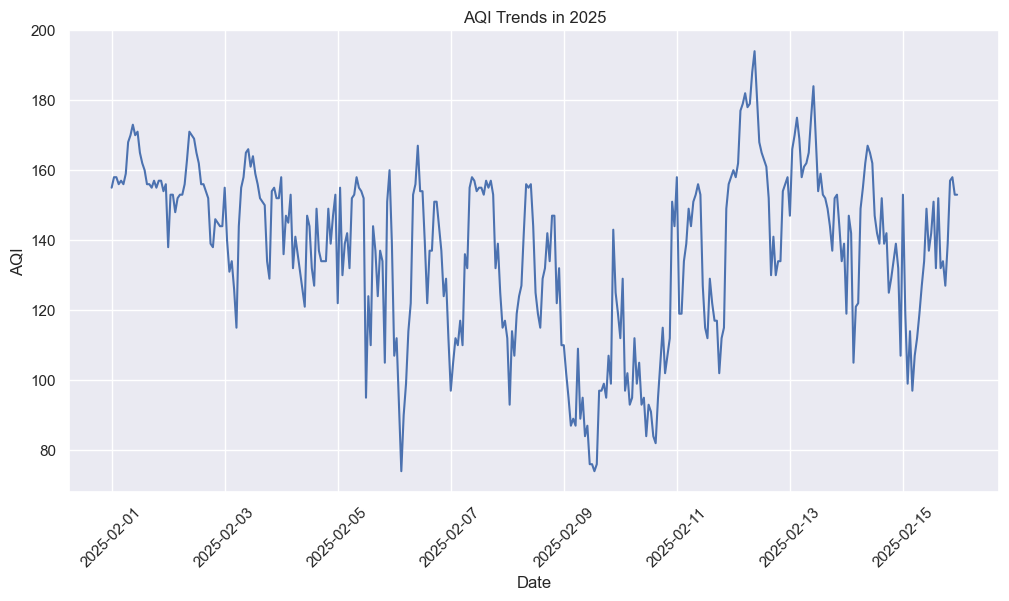

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_theme(style="darkgrid")

# Plot AQI data over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=aqi_data.index, y=aqi_data["aqi"])

plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("AQI Trends in 2025")
plt.xticks(rotation=45)
plt.show()

In [50]:
arima_model, _ = arima_model_result
sarima_model, _ = sarima_model_result
sarimax_model, _ = sarimax_model_result

In [57]:
from datetime import datetime

forecast_steps = 12  # Number of hours to forecast

# Step 1: Get the current time
current_time = datetime.now()

# Step 2: Find the latest time in the data that is before or equal to the current time
latest_time = aqi_data.index.max()

# Find the closest past time in the dataset
if current_time > latest_time:
    last_known_time = latest_time
else:
    last_known_time = aqi_data[aqi_data.index <= current_time].index.max()

# Step 3: Forecast from that point onwards
# Create a forecast index for the next 6 hours
forecast_index = pd.date_range(start=last_known_time, periods=forecast_steps + 1, freq='H')[1:]  # Forecast the next 6 hours

# Step 4: Prepare exogenous data (if using SARIMAX, use weather data for the forecast period)
# Prepare exogenous data for the forecast period
last_known_weather = weather[weather['datetime'] == last_known_time][['temperature', 'humidity']].values
weather_forecast_data = pd.DataFrame(np.tile(last_known_weather, (forecast_steps, 1)), columns=['temperature', 'humidity'])

# Step 5: Use the models to forecast (ARIMA, SARIMA, or SARIMAX)
# Ensure that you're passing the right parameters (like exogenous data for SARIMAX)
arima_forecast = arima_model.forecast(steps=forecast_steps)
sarima_forecast = sarima_model.forecast(steps=forecast_steps)
sarimax_forecast = sarimax_model.forecast(steps=forecast_steps, exog=weather_forecast_data[['temperature', 'humidity']])

# Step 6: Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({
    'datetime': forecast_index,
    'arima_forecast': arima_forecast,
    'sarima_forecast': sarima_forecast,
    'sarimax_forecast': sarimax_forecast
})

# Step 7: Convert 'time' column to a proper datetime format if it's not already
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])

# Step 8: Set 'time' as the index for better formatting
forecast_df.set_index('datetime', inplace=True)

print(forecast_df)

                     arima_forecast  sarima_forecast  sarimax_forecast
datetime                                                              
2025-02-16 00:00:00      125.999995       130.283399        325.056717
2025-02-16 01:00:00      125.999995       167.731165        362.949393
2025-02-16 02:00:00      125.999995       120.858234        317.263848
2025-02-16 03:00:00      125.999995       152.821917        347.972114
2025-02-16 04:00:00      125.999995       125.660418        319.695312
2025-02-16 05:00:00      125.999995        72.222468        267.926018
2025-02-16 06:00:00      125.999995       119.948623        313.743291
2025-02-16 07:00:00      125.999995       121.613823        318.225533
2025-02-16 08:00:00      125.999995       120.582014        316.798687
2025-02-16 09:00:00      125.999995       166.138728        361.013478
2025-02-16 10:00:00      125.999995       131.144811        324.767193
2025-02-16 11:00:00      125.999995       168.730533        363.948715


In [58]:
# Define folder path (relative to script location)
folder_path = r"D:\aqi_forecast_arima\AQI_forecast_arima\results"

# Ensure the folder exists
import os
os.makedirs(folder_path, exist_ok=True)

# Save CSV inside the folder
forecast_df.to_csv(f"{folder_path}/forecast_aqi.csv", index=True)

print("Saved to forecast_data/forecast.csv")

Saved to forecast_data/forecast.csv


In [56]:
forecast_df

,arima_forecast,sarima_forecast,sarimax_forecast
datetime,,,
2025-02-16 00:00:00,125.999995,130.283399,325.056717
2025-02-16 01:00:00,125.999995,167.731165,362.949393
2025-02-16 02:00:00,125.999995,120.858234,317.263848
2025-02-16 03:00:00,125.999995,152.821917,347.972114
2025-02-16 04:00:00,125.999995,125.660418,319.695312
2025-02-16 05:00:00,125.999995,72.222468,267.926018


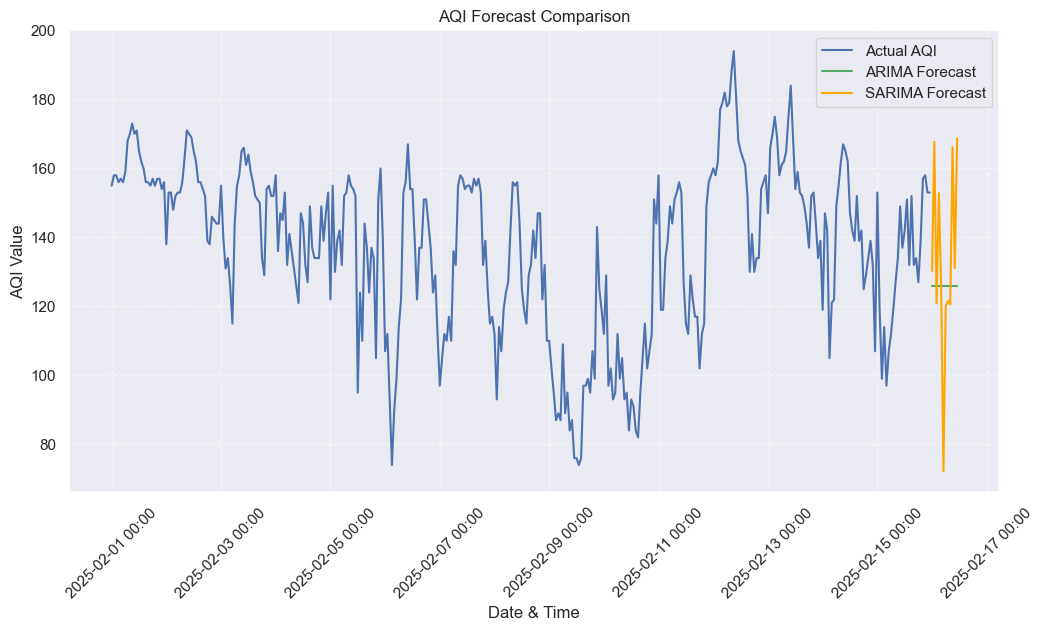

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))  # Increase figure size for better readability

plt.plot(aqi_data, label="Actual AQI", color="b")
plt.plot(forecast_df['arima_forecast'], label="ARIMA Forecast", color="g")
plt.plot(forecast_df['sarima_forecast'], label="SARIMA Forecast", color="orange")

plt.xlabel("Date & Time")
plt.ylabel("AQI Value")
plt.title("AQI Forecast Comparison")

# Format x-axis to show better datetime labels
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format datetime

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()
